## Polygons

In [9]:
import geopandas as gpd
import math
import numpy as np

# Load the shapefile
shapefile_path = 'C:\\Users\\User\\Downloads\\GTAA_SHAPEFILES\\GTAA_POLYGON.shp'

gdf = gpd.read_file(shapefile_path)

# exploding
gdf = gdf.explode(index_parts=True).reset_index()


# Function to compute aspect ratio using the minimum bounding rectangle
def compute_aspect_ratio(geometry):
    if geometry is None or geometry.is_empty:
        return np.nan

    # Get the bounding box (minimum rotated rectangle)
    min_rect = geometry.minimum_rotated_rectangle

    # Get the rectangle's corner points
    coords = list(min_rect.exterior.coords)

    # Compute distances of rectangle edges
    edge_lengths = [np.linalg.norm(
        np.array(coords[i]) - np.array(coords[i+1])) for i in range(3)]

    # Major & minor axis are the longest & shortest edge
    major_axis = max(edge_lengths)
    minor_axis = min(edge_lengths)

    # Avoid division by zero
    if minor_axis == 0:
        return np.nan

    return major_axis / minor_axis

def compute_num_vertices(geometry):
    if geometry == None:
            return
    
    if geometry.geom_type == 'Polygon':
        return len(geometry.exterior.coords)
    elif geometry.geom_type == 'MultiPolygon':
        return sum(len(part.exterior.coords) for part in geometry.geoms)
    else:
        return None
    
# Calculate convexity
def compute_convexity(geom):
    if geom.geom_type in ['Polygon', 'MultiPolygon']:
        polygon_perimeter = geom.length
        hull_perimeter = geom.convex_hull.length
        return hull_perimeter / polygon_perimeter if polygon_perimeter > 0 else 0
    return None


# Create a spatial index (R-tree index)
sindex = gdf.sindex

# Function to compute neighbors
def compute_neighbors_optimized(gdf):
    neighbors_count = []

    # Loop over each polygon
    for idx, polygon in gdf.iterrows():
        neighbors = 0
        # Use the spatial index to find candidates that might be neighbors
        possible_neighbors = list(
            sindex.intersection(polygon['geometry'].bounds))

        # Loop through possible neighbors based on spatial index results
        for candidate_idx in possible_neighbors:
            candidate = gdf.iloc[candidate_idx]
            try:
            # Check if the polygons actually touch or intersect
                if polygon['geometry'].touches(candidate['geometry']) and polygon['geometry'] != candidate['geometry']:
                    neighbors += 1
            except:
                pass

        neighbors_count.append(neighbors)

    return neighbors_count

def compute_overlapping_shapes_optimized(gdf):
    neighbors_count = []

    # Loop over each polygon
    for idx, polygon in gdf.iterrows():
        neighbors = 0
        # Use the spatial index to find candidates that might be neighbors
        possible_neighbors = list(
            sindex.intersection(polygon['geometry'].bounds))

        # Loop through possible neighbors based on spatial index results
        for candidate_idx in possible_neighbors:
            candidate = gdf.iloc[candidate_idx]
            try:
                # Check if the polygons actually touch or intersect
                if polygon['geometry'].intersects(candidate['geometry']) and polygon['geometry'] != candidate['geometry']:
                    neighbors += 1
            except:
                pass

        neighbors_count.append(neighbors)

    return neighbors_count


def calculate_shared_boundary(poly):
    res = 0
    # Use spatial index to find potential neighbors
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = gdf.iloc[possible_matches_index].geometry

    for other in possible_matches:
        if poly == other:
            continue

        try:
            # Only compute intersection if geometries are actually touching
            if poly.touches(other) or poly.overlaps(other):
                res += poly.intersection(other).length
        except:
            pass

    return res

def compute_overlap_area(gdf):
    # Ensure geometries are valid
    gdf['geometry'] = gdf['geometry'].buffer(0)
    
    # Create spatial index for faster lookups
    sindex = gdf.sindex
    
    # Initialize results
    overlap_areas = []

    # Loop over each polygon
    for idx, poly1 in gdf.iterrows():
        # Get candidate polygons using spatial index (bounding box intersection)
        possible_matches_index = list(sindex.intersection(poly1.geometry.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        
        # Calculate the intersection area with every other polygon
        total_overlap_area = sum(
            poly1.geometry.intersection(poly2.geometry).area
            for i, poly2 in possible_matches.iterrows()
            if idx != i and not poly1.geometry.intersection(poly2.geometry).is_empty
        )
        
        overlap_areas.append(total_overlap_area)

    return overlap_areas
    
# Compute aspect ratio for each polygon
gdf["area"] = gdf.geometry.area
gdf["perimeter"] = gdf.geometry.length
gdf["compactness"] = (4 * np.pi * gdf["area"]) / (gdf["perimeter"] ** 2)
gdf["aspect_ratio"] = gdf.geometry.apply(compute_aspect_ratio)
gdf["num_vertices"] = gdf.geometry.apply(compute_num_vertices)
gdf["vertex_density"] = gdf["num_vertices"] / gdf["perimeter"]
gdf["comvexity"] = gdf.geometry.apply(compute_convexity)
gdf["neighbor_touch_count"] = compute_neighbors_optimized(gdf)
gdf["number_overlapping"] = compute_overlapping_shapes_optimized(gdf)
gdf['shared_boundary'] = gdf.geometry.apply(calculate_shared_boundary)
gdf['overlapping_area_sum'] = compute_overlap_area(gdf)

# Export the GeoDataFrame to CSV
output_path = '.\\GTAA_POLYGON_with_metrics.csv'
gdf.to_csv(output_path, index=False)


## Polyline

In [9]:
import geopandas as gpd
import math
import numpy as np
from shapely import Point

# Load the shapefile
shapefile_path = 'C:\\Users\\User\\Downloads\\GTAA_SHAPEFILES\\GTAA_POLYLINE.shp'
gdf = gpd.read_file(shapefile_path)

# exploding
gdf = gdf.explode(index_parts=True).reset_index()

gdf = gdf.head(1000)

# Create a spatial index (R-tree index)
sindex = gdf.sindex


def compute_line_properties(geometry):
    if geometry is None or geometry.is_empty:
        return np.nan, np.nan

    # Get start and end points
    start_point = Point(geometry.coords[0])
    end_point = Point(geometry.coords[-1])

    # Calculate actual length and straight-line distance
    actual_length = geometry.length
    straight_length = start_point.distance(end_point)

    # Calculate sinuosity (ratio of actual length to straight-line distance)
    sinuosity = actual_length / straight_length if straight_length > 0 else np.nan

    return actual_length, sinuosity


def compute_num_vertices(geometry):
    if geometry is None:
        return None

    if geometry.geom_type == 'LineString':
        return len(geometry.coords)
    elif geometry.geom_type == 'MultiLineString':
        return sum(len(line.coords) for line in geometry.geoms)
    else:
        return None


def compute_vertex_density(geometry):
    if geometry is None or geometry.is_empty:
        return np.nan

    num_vertices = compute_num_vertices(geometry)
    length = geometry.length

    return num_vertices / length if length > 0 else np.nan


def compute_connected_lines(gdf):
    connections_count = []

    # Loop over each line
    for idx, line in gdf.iterrows():
        connections = 0
        # Use spatial index to find potential connections
        possible_neighbors = list(sindex.intersection(line['geometry'].bounds))

        # Get endpoints of current line
        start_point = Point(line['geometry'].coords[0])
        end_point = Point(line['geometry'].coords[-1])

        # Check each potential neighbor
        for neighbor_idx in possible_neighbors:
            if neighbor_idx == idx:
                continue

            neighbor = gdf.iloc[neighbor_idx]
            try:
                # Get endpoints of neighbor line
                neighbor_start = Point(neighbor['geometry'].coords[0])
                neighbor_end = Point(neighbor['geometry'].coords[-1])

                # Check if any endpoints touch
                if (start_point.distance(neighbor_start) < 1e-8 or
                    start_point.distance(neighbor_end) < 1e-8 or
                    end_point.distance(neighbor_start) < 1e-8 or
                        end_point.distance(neighbor_end) < 1e-8):
                    connections += 1
            except:
                pass

        connections_count.append(connections)

    return connections_count


def compute_intersecting_lines(gdf):
    intersections_count = []

    # Loop over each line
    for idx, line in gdf.iterrows():
        intersections = 0
        # Use spatial index to find potential intersections
        possible_neighbors = list(sindex.intersection(line['geometry'].bounds))

        # Check each potential neighbor
        for neighbor_idx in possible_neighbors:
            if neighbor_idx == idx:
                continue

            neighbor = gdf.iloc[neighbor_idx]
            try:
                if line['geometry'].crosses(neighbor['geometry']):
                    intersections += 1
            except:
                pass

        intersections_count.append(intersections)

    return intersections_count


def compute_angle_changes(geometry):
    if geometry is None or geometry.is_empty:
        return np.nan

    coords = list(geometry.coords)
    if len(coords) < 3:
        return 0

    total_angle_change = 0
    for i in range(len(coords) - 2):
        # Get three consecutive points
        p1 = np.array(coords[i])
        p2 = np.array(coords[i + 1])
        p3 = np.array(coords[i + 2])

        # Calculate vectors
        v1 = p2 - p1
        v2 = p3 - p2

        # Calculate angle between vectors
        dot_product = np.dot(v1, v2)
        norms = np.linalg.norm(v1) * np.linalg.norm(v2)

        if norms > 0:
            cos_angle = dot_product / norms
            # Ensure the value is within [-1, 1] to avoid numerical errors
            cos_angle = np.clip(cos_angle, -1.0, 1.0)
            angle = np.arccos(cos_angle)
            total_angle_change += np.degrees(angle)

    return total_angle_change


def is_open_polyline(line):
    return not line.is_ring


# Compute metrics for each line
gdf['length'], gdf['sinuosity'] = zip(
    *gdf.geometry.apply(compute_line_properties))
gdf['num_vertices'] = gdf.geometry.apply(compute_num_vertices)
gdf['vertex_density'] = gdf.geometry.apply(compute_vertex_density)
gdf['connected_lines'] = compute_connected_lines(gdf)
gdf['intersecting_lines'] = compute_intersecting_lines(gdf)
gdf['total_angle_change'] = gdf.geometry.apply(compute_angle_changes)

# Compute bounding box of the Polyline
gdf['bounding_box'] = gdf.geometry.apply(lambda x: x.bounds)

# Compute centroid of the Polyline
gdf['centroid'] = gdf.geometry.centroid

# Compute curvature of the Polyline (Angle Change / Path Length)
gdf['curvature'] = gdf.apply(lambda row: row['total_angle_change'] / row['length'] if row['length'] != 0 else np.nan, axis=1)

# Boolean value for whether the endpoints form a loop or not
gdf['is_open'] = gdf['geometry'].apply(is_open_polyline)






# Print summary statistics
print("\nSummary Statistics:")
# print(gdf[['length', 'sinuosity', 'num_vertices', 'vertex_density',
#            'connected_lines', 'intersecting_lines', 'total_angle_change']].describe())

output_path = '.\\GTAA_POLYLINE_with_metrics.csv'
gdf.to_csv(output_path)


Summary Statistics:


## **Feature Processing**

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString

# NUMBER OF DATA POINTS
NUM_DATA_POINTS = 10000

print('Reading Shapefile...')

# Load the shapefile
shapefile_path = '.\\GTAA_errors\\GTAA_errors.shp'
gdf = gpd.read_file(shapefile_path)
print('Shapefile Loaded!\n')

# exploding
gdf = gdf.explode(index_parts=True).reset_index()

class DataProcessing:
    completedCount = 0

    def remove_duplicates(self, gdf):
        gdf_temp = gdf.iloc[:, 1:].copy()
        gdf_temp = gdf_temp.drop(columns=['Error'])
        dup_mask = gdf_temp.duplicated(keep='first')

        gdf_res = gdf[~dup_mask]
        gdf_res.loc[:, 'Error'] = gdf_res['Error'].apply(lambda x: 0 if x == 2 else x)
        return gdf_res

    def compute_linestring_metrics(self, linestring):
        """
        Computes multiple metrics for a LINESTRING Z:
        - is_closed: Whether the linestring forms a closed path.
        - length_3d: The total 3D length of the linestring.
        - line_curvature: The ratio of actual path length to straight-line distance.
        - num_vertices: The number of vertices in the linestring.
        - vertex_density: The number of vertices per unit length.
        - total_angle_change: The sum of absolute angle changes between segments.
        - is_point: Whether the linestring consists of a single repeated point.
        - num_connections: Number of other lines that touch this line, but don't go through (i.e. a 3-way intersection, not a 4-way intersection)
        - num_intersections: Number of other lines that pass through this line
        - bounding_box_width: The width of the bounding box of the linestring.
        - bounding_box_height: The height of the bounding box of the linestring.
        - relative_angle_change: Ratio of total_angle_change to length of the line. (Relative Angle Change to Line Length)
        - proximity_to_neighbors: The average minimum distance to neighboring lines.
        - similarity_score: Similarity score with close neighbor lines based on selected metrics (length, curvature, vertices) and normalized based on neighbor group
        - num_neighbors: Number of neighboring lines within a radius equal to 1% of the total map size.
        """
        if not isinstance(linestring, LineString) or len(linestring.coords) < 2:
            return False, 0.0, 1.0, 0, 0.0, 0.0, True, 0, 0 ,0.0, 0.0, 0.0, 0.0, 0.0, 0 # Defaults for invalid linestrings

        coords = np.array(linestring.coords)
        first_point = coords[0]
        last_point = coords[-1]
        is_closed = np.array_equal(first_point, last_point)

        diffs = np.diff(coords, axis=0)
        segment_lengths = np.linalg.norm(diffs, axis=1)
        sum_length = np.sum(segment_lengths)

        straight_line_distance = np.linalg.norm(last_point - first_point)
        line_curvature = sum_length / straight_line_distance if straight_line_distance > 0 else 1.0

        num_vertices = len(coords)

        # Vertices per unit length
        vertex_density = num_vertices / sum_length if sum_length > 0 else 0.0

        # Compute total angle change
        if len(linestring.coords) == 2:
            total_angle_change = 0.0
        else:
            valid_segments = segment_lengths > 0
            unit_vectors = diffs[valid_segments] / segment_lengths[:, None][valid_segments]
            dot_products = np.einsum("ij,ij->i", unit_vectors[:-1], unit_vectors[1:])
            angles = np.arccos(np.clip(dot_products, -1.0, 1.0))
            # Ensure we sum all angle changes without taking absolute values
            total_angle_change = np.sum(angles)

        # Check if all coordinates are the same (i.e., single repeated point)
        is_point = np.all(coords == coords[0])

        # Compute number of connections (lines that share at least one point)
        connected_lines_idx = list(spatial_index.intersection(linestring.bounds))
        connected_lines = gdf.iloc[connected_lines_idx]
        # Subtract 1 to exclude the line itself
        num_connections = sum(connected_lines.geometry.touches(linestring)) 

        # Compute number of lines that intersect with this line
        intersecting_lines_idx = list(
            spatial_index.intersection(linestring.bounds))
        intersecting_lines = gdf.iloc[intersecting_lines_idx]
        # Subtract 1 to exclude the line itself
        num_intersections = sum(intersecting_lines.geometry.intersects(linestring)) - 1

        # Compute bounding box width and height
        minx, miny, maxx, maxy = linestring.bounds
        bounding_box_width = maxx - minx
        bounding_box_height = maxy - miny

        # Get the bounding box of the current line
        buffered_line = linestring.buffer(search_radius)
        possible_neighbors = list(spatial_index.intersection(buffered_line.bounds))

        num_neighbors = len(possible_neighbors) - 1

        # Compute proximity to neighbors (average minimum distance)
        min_distances = []
        for neighbor_idx in possible_neighbors:
            neighbor = gdf.iloc[neighbor_idx].geometry
            if neighbor != linestring:  # Avoid self-comparison
                distance = linestring.distance(neighbor)
                min_distances.append(distance)

        # If there are neighbors, compute the average distance
        proximity_to_neighbors = search_radius * 2
        # Compute weighted proximity: Closer neighbors have higher weight
        if min_distances:
            weights = [1 / d if d > 0 else 1 for d in min_distances]
            proximity_to_neighbors = np.average(min_distances, weights=weights)
        else:
            proximity_to_neighbors = search_radius * 2  # Default if no neighbors

        # Compute similarity score with neighbors
        similarity_score = 0.0
        neighbor_metrics = []
        for neighbor_idx in possible_neighbors:
            neighbor = gdf.iloc[neighbor_idx].geometry
            if neighbor != linestring:  # Avoid self-comparison
                neighbor_coords = np.array(neighbor.coords)
                neighbor_diffs = np.diff(neighbor_coords, axis=0)
                neighbor_segment_lengths = np.linalg.norm(neighbor_diffs, axis=1)
                neighbor_sum_length = np.sum(neighbor_segment_lengths)

                neighbor_first_point = coords[0]
                neighbor_last_point = coords[-1]
                neighbor_straight_line_distance = np.linalg.norm(
                    neighbor_last_point - neighbor_first_point)
                neighbor_line_curvature = neighbor_sum_length / \
                    neighbor_straight_line_distance if neighbor_straight_line_distance > 0 else 1.0
                
                neighbor_num_vertices = len(neighbor_coords)

                neighbor_metrics.append(
                    [neighbor_sum_length, neighbor_line_curvature, neighbor_num_vertices])

        # Extract and normalize metrics for the neighbor group
        lengths = np.array([metrics[0] for metrics in neighbor_metrics])
        curvatures = np.array([metrics[1] for metrics in neighbor_metrics])
        vertices = np.array([metrics[2] for metrics in neighbor_metrics])

        # Normalize the current line's metrics against the neighbor group
        length_mean, length_std = np.mean(lengths), np.std(lengths)
        curvature_mean, curvature_std = np.mean(curvatures), np.std(curvatures)
        vertices_mean, vertices_std = np.mean(vertices), np.std(vertices)

        normalized_length = (sum_length - length_mean) / \
            length_std if length_std > 0 else 0.0
        normalized_curvature = (line_curvature - curvature_mean) / \
            curvature_std if curvature_std > 0 else 0.0
        normalized_vertices = (num_vertices - vertices_mean) / \
            vertices_std if vertices_std > 0 else 0.0

        # Calculate similarity score using normalized metrics
        if (num_neighbors > 0):
            similarity_score = 1 / (1 + abs(normalized_length) + abs(normalized_curvature) +
                                abs(normalized_vertices))

        relative_angle_change = total_angle_change / sum_length if sum_length != 0 else 0

        self.completedCount += 1
        if self.completedCount % 1000 == 0:
            print(f'Finished {self.completedCount} rows')

        return is_closed, sum_length, line_curvature, num_vertices, vertex_density, total_angle_change, is_point, num_connections, num_intersections, bounding_box_width, bounding_box_height, relative_angle_change, proximity_to_neighbors, similarity_score, num_neighbors

gdf = gdf.reset_index()
gdf['id'] = gdf['index']

processing = DataProcessing()
# Shuffle the GeoDataFrame and take the top 10,000 rows
# Shuffling the GeoDataFrame
gdf = processing.remove_duplicates(gdf)

gdf1 = gdf[gdf['Error'] == 1]
gdf2 = gdf[gdf['Error'] != 1]
gdf2 = gdf2.head(NUM_DATA_POINTS)  # Take the top 10,000 rows
gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))

gdf = gdf.sample(frac=1, random_state=42)
gdf = gdf.reset_index(drop=True)
spatial_index = gdf.sindex

print('Duplicates Removed + Random Sampling + Set Spacial Index\n')

minx, miny, maxx, maxy = gdf.total_bounds

# Compute the width and height of the bounding box
bbox_width = maxx - minx
bbox_height = maxy - miny
search_radius = 0.01 * max(bbox_width, bbox_height)

print('Computing Features...')
# Apply the function and ensure the output shape matches the expected columns
metrics = gdf.geometry.apply(processing.compute_linestring_metrics)
print('Features Computed!\n')

# Convert the result to a DataFrame and check the lengths
metrics_df = pd.DataFrame(metrics.tolist(), columns=[
                          "is_closed", "sum_length", "line_curvature", "num_vertices", "vertex_density", "total_angle_change", "is_point", "num_connections", "num_intersections", "bounding_box_width", "bounding_box_height", "relative_angle_change", "proximity_to_neighbors", "similarity_score", "num_neighbors"])

# Assign the calculated metrics to the original GeoDataFrame
gdf = gdf.join(metrics_df)

# Compute metrics for each line
columns = ["id", "is_closed", "sum_length", "line_curvature", "num_vertices", "vertex_density",
           "total_angle_change", "is_point", "num_connections", "num_intersections", "bounding_box_width", "bounding_box_height", "relative_angle_change", "proximity_to_neighbors", "similarity_score", "num_neighbors", "Error"]
gdf_features = gdf[columns]
gdf_features = gdf_features.reset_index()
print('Final Training Set Created with Labels')

output_path = '.\\GTAA_Errors_with_metrics.csv'
gdf_features.to_csv(output_path, index=False)
print('Training Set Stored')

KeyboardInterrupt: 

In [66]:
print(gdf[['geometry']])

                                                 geometry
0       LINESTRING Z (609028.044 4838381.721 0, 609028...
1       LINESTRING Z (609025.924 4838380.128 0, 609025...
2       LINESTRING Z (609024.331 4838381.717 0, 609024...
3       LINESTRING Z (609025.921 4838383.31 0, 609026....
4       LINESTRING Z (609028.044 4838381.721 0, 609028...
...                                                   ...
162399  LINESTRING Z (609757.796 4838065.622 0, 609750...
162400  LINESTRING Z (609056.916 4838089 0, 609138.352...
162401  LINESTRING Z (609064.663 4838129.67 0, 609062....
162402  LINESTRING Z (608991.717 4838072.881 0, 608992...
162403  LINESTRING Z (608999.066 4838065.382 0, 608999...

[162404 rows x 1 columns]


## DWG-CAD Features

In [25]:
import ezdxf
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import transform
from pyproj import CRS, Transformer


def extract_geometries_from_dwg(dwg_path):
    doc = ezdxf.readfile(dwg_path)
    msp = doc.modelspace()

    geometries = []
    for entity in msp:
        if entity.dxftype() == 'LWPOLYLINE' or entity.dxftype() == 'POLYLINE':
            points = [(p[0], p[1]) for p in entity.get_points()]
            geometry = Polygon(
                points) if entity.is_closed else LineString(points)
            geometries.append(geometry)
        elif entity.dxftype() == 'CIRCLE':
            center = entity.dxf.center
            radius = entity.dxf.radius
            geometry = Point(center).buffer(radius)
            geometries.append(geometry)
    return gpd.GeoDataFrame(geometry=geometries, crs="EPSG:4326")


def map_shapes(dwg_path, shp_path):
    # Extract geometries from DWG
    dwg_gdf = extract_geometries_from_dwg(dwg_path)

    # Load shapefile
    shp_gdf = gpd.read_file(shp_path)

    # Ensure CRS match
    if dwg_gdf.crs != shp_gdf.crs:
        shp_gdf = shp_gdf.to_crs(dwg_gdf.crs)

    # Create spatial indices for faster searching
    dwg_gdf['geometry'] = dwg_gdf['geometry'].buffer(0)
    shp_gdf['geometry'] = shp_gdf['geometry'].buffer(0)
    dwg_index = dwg_gdf.sindex
    shp_index = shp_gdf.sindex

    # Mapping using Intersection Over Union (IoU)
    shape_mapping = {}
    for dwg_idx, dwg_shape in dwg_gdf.iterrows():
        possible_matches_index = list(
            shp_index.intersection(dwg_shape.geometry.bounds))
        possible_matches = shp_gdf.iloc[possible_matches_index]

        best_match = None
        best_score = 0

        for shp_idx, shp_shape in possible_matches.iterrows():
            intersection_area = dwg_shape.geometry.intersection(
                shp_shape.geometry).area
            union_area = dwg_shape.geometry.union(shp_shape.geometry).area
            iou = intersection_area / union_area if union_area > 0 else 0

            if iou > best_score:
                best_score = iou
                best_match = shp_idx

        if best_match is not None:
            shape_mapping[dwg_idx] = best_match

    print("Shape Mapping Complete:", shape_mapping)
    return shape_mapping


# Example usage
cad_path = '.\\GTAA.dwg'
shp_path = 'C:\\Users\\User\\Downloads\\GTAA_SHAPEFILES\\GTAA_POLYGON.shp'
result = map_shapes(cad_path, shp_path)
print(result)

KeyboardInterrupt: 

In [ ]:

def map_shapes(cad_path, shp_path):
    # Load CAD and SHP files
    cad_gdf = gpd.read_file(cad_path)
    shp_gdf = gpd.read_file(shp_path)

    # Ensure the CRS matches
    if cad_gdf.crs != shp_gdf.crs:
        shp_gdf = shp_gdf.to_crs(cad_gdf.crs)

    # Create a mapping dictionary
    shape_mapping = {}

    # Iterate through CAD shapes to find corresponding SHP shapes
    for cad_index, cad_shape in cad_gdf.iterrows():
        best_match = None
        best_score = float('inf')

        for shp_index, shp_shape in shp_gdf.iterrows():
            # Compute Hausdorff distance or Intersection over Union (IoU)
            intersection_area = cad_shape.geometry.intersection(
                shp_shape.geometry).area
            union_area = cad_shape.geometry.union(shp_shape.geometry).area
            iou = intersection_area / union_area if union_area > 0 else 0

            # Check for the highest overlap using IoU
            if iou > 0.7 and iou < best_score:
                best_match = shp_index
                best_score = iou

        # Save the mapping
        if best_match is not None:
            shape_mapping[cad_index] = best_match

    return shape_mapping


# Example usage
cad_path = 'path_to_cad_file.dxf'
shp_path = 'path_to_shapefile.shp'
result = map_shapes(cad_path, shp_path)
print(result)

In [6]:
import geopandas as gpd
import math
import numpy as np

# Load the shapefile
shapefile_path = 'C:\\Users\\User\\Downloads\\Errors'
gdf = gpd.read_file(shapefile_path)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [3]:
print(gdf[["overlapping_area_sum"]])

print(gdf.geom_type)

      overlapping_area_sum
0                 0.562684
1                 8.721594
2                24.758081
3              2655.303545
4                 0.000000
...                    ...
1311           3048.986625
1312           3089.030197
1313              0.000000
1314              0.000000
1315              0.000000

[1316 rows x 1 columns]
0       Polygon
1       Polygon
2       Polygon
3       Polygon
4       Polygon
         ...   
1311    Polygon
1312    Polygon
1313    Polygon
1314    Polygon
1315    Polygon
Length: 1316, dtype: object


In [44]:
import geopandas as gpd

# Load the shapefile
shapefile_path = 'C:\\Users\\User\\Downloads\\GTAA_SHAPEFILES\\GTAA_POLYLINE.shp'
gdf = gpd.read_file(shapefile_path)

# Extract specific features (geometry, attributes, etc.)
# print("Columns:", gdf.columns)
# print("Geometry:", gdf.geometry.head(1000))
# print(gdf.geometry.head(5)[0])

# print(12)
# gdf["area"] = gdf.geometry.area
# gdf["perimeter"] = gdf.geometry.length
# print(gdf[["area", "perimeter"]])
print(gdf)

# Get unique geometry types
geometry_types = gdf.geometry.geom_type.unique()
print(len(geometry_types))

# Split and save each geometry type separately
for geom_type in geometry_types:
    subset = gdf[gdf.geometry.geom_type == geom_type]
    print(geom_type)
    print(subset)
    print()

         Entity  Handle                    Layer  LyrFrzn  LyrLock  LyrOn  \
0        Insert     3FA                        0        0        0      1   
1        Insert     4D5              SP-E-RNW-PV        0        0      1   
2        Spline  157DC0              SP-E-RDW-PV        0        0      1   
3        Spline  157DC1              SP-E-RDW-PV        0        0      1   
4        Spline  157DC2              SP-E-RDW-PV        0        0      1   
..          ...     ...                      ...      ...      ...    ...   
185      Insert  5B7DC6                        0        0        0      1   
186      Insert  5B8426                        0        0        0      1   
187      Insert  6195F6                        0        0        0      1   
188  LWPolyline  61D5E5                        0        0        0      1   
189  LWPolyline  61D625  GTA-C2-INTERIM TERMINAL        0        0      1   

     LyrVPFrzn LyrHandle  Color  EntColor  ...  ExtZ     DocName  \
0      

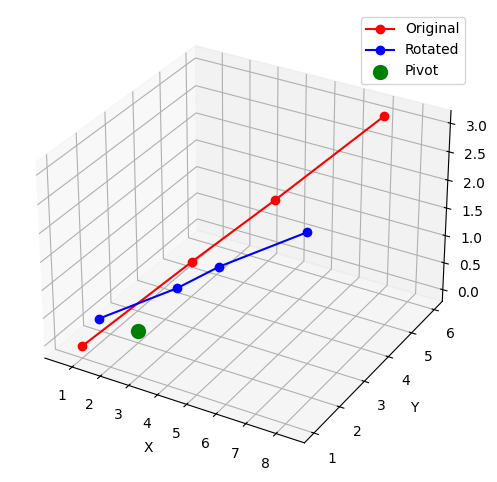

In [66]:
import numpy as np
import matplotlib.pyplot as plt


def rotate_stringline_z_about_point(points, pivot):
    """
    Rotates a 3D stringline around a specified pivot so that its first segment aligns with the X-axis.

    :param points: Nx3 NumPy array of 3D points (x, y, z)
    :param pivot: 3-element tuple (px, py, pz) specifying the rotation pivot
    :return: Rotated Nx3 NumPy array
    """
    points = np.array(points)  # Ensure NumPy array
    pivot = np.array(pivot)    # Convert pivot to NumPy array

    # Compute the angle of the first segment in the XY-plane
    dx = points[1, 0] - points[0, 0]  # x2 - x1
    dy = points[1, 1] - points[0, 1]  # y2 - y1
    angle = np.arctan2(dy, dx)  # Angle in radians

    # Compute the 3D rotation matrix for the Z-axis
    cos_theta, sin_theta = np.cos(-angle), np.sin(-angle)
    rotation_matrix = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta,  0],
        [0,         0,          1]
    ])

    # Step 1: Translate points so pivot is at the origin
    translated_points = points - pivot

    # Step 2: Rotate the translated points
    rotated_points = translated_points @ rotation_matrix.T

    # Step 3: Translate back to the original pivot position
    rotated_points += pivot

    return rotated_points


# Example 3D stringline (polyline)
stringline = np.array([
    [1, 1, 0],  # Start point
    [3, 3, 1],  # Second point
    [5, 4, 2],  # Third point
    [7, 6, 3]   # Fourth point
])

# Specify pivot point (can be the first point or another reference)
pivot_point = (2, 2, 0)

# Rotate the stringline about the pivot
rotated_stringline = rotate_stringline_z_about_point(stringline, pivot_point)

# Plot original and rotated stringlines in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Original stringline (red)
ax.plot(*stringline.T, 'ro-', label="Original")

# Rotated stringline (blue)
ax.plot(*rotated_stringline.T, 'bo-', label="Rotated")

# Mark pivot point
ax.scatter(*pivot_point, color="green", s=100, label="Pivot")

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

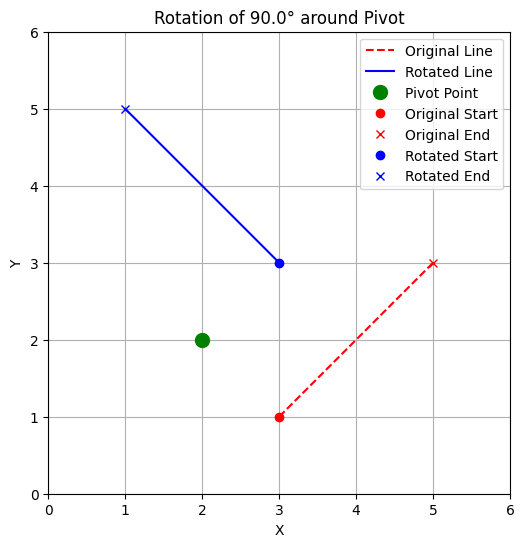

In [69]:
import numpy as np
import matplotlib.pyplot as plt


def rotate_point_2d(point, pivot, angle):
    """Rotates a 2D point around a specified pivot by a given angle."""
    x, y = point
    px, py = pivot

    # Translate point so pivot is at origin
    translated_x = x - px
    translated_y = y - py

    # Apply 2D rotation matrix
    cos_theta, sin_theta = np.cos(angle), np.sin(angle)
    rotated_x = translated_x * cos_theta - translated_y * sin_theta
    rotated_y = translated_x * sin_theta + translated_y * cos_theta

    # Translate back
    new_x = rotated_x + px
    new_y = rotated_y + py

    return new_x, new_y


def rotate_line_2d(line, pivot, angle):
    """Rotates a 2D line (start and end points) around a pivot."""
    p1_rotated = rotate_point_2d(line[0], pivot, angle)
    p2_rotated = rotate_point_2d(line[1], pivot, angle)
    return p1_rotated, p2_rotated


# Example Usage
line = [(3, 1), (5, 3)]  # Line segment (start and end points)
pivot = (2, 2)           # Pivot point
angle = np.radians(90)   # Rotation angle (90 degrees counterclockwise)

# Compute rotated line
rotated_line = rotate_line_2d(line, pivot, angle)

# Visualization
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

# Plot original and rotated lines
ax.plot(*zip(*line), 'r--', label="Original Line")  # Red dashed line
ax.plot(*zip(*rotated_line), 'b-', label="Rotated Line")  # Blue solid line

# Mark pivot and endpoints
ax.plot(*pivot, 'go', markersize=10, label="Pivot Point")  # Green pivot
ax.plot(*line[0], 'ro', label="Original Start")  # Red start
ax.plot(*line[1], 'rx', label="Original End")  # Red end
ax.plot(*rotated_line[0], 'bo', label="Rotated Start")  # Blue start
ax.plot(*rotated_line[1], 'bx', label="Rotated End")  # Blue end

# Labels and legend
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
ax.set_title(f"Rotation of {np.degrees(angle):.1f}° around Pivot")

plt.grid(True)
plt.show()

In [73]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString, MultiLineString
from rtree import index


def remove_duplicates(gdf):
    gdf_temp = gdf.iloc[:, 1:].copy()
    gdf_temp = gdf_temp.drop(columns=['Error'])
    dup_mask = gdf_temp.duplicated(keep='first')

    gdf_res = gdf[~dup_mask]
    gdf_res.loc[:, 'Error'] = gdf_res['Error'].apply(
        lambda x: 0 if x == 2 else x)
    return gdf_res


# Manage LineStrings for each row
# When 2 LineStrings have different roots, then update the lineString in the one that becomes the new root. Possibly can also set the dropped root to None for safety
# Now develop a model that merges 2 LineStrings.


class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])  # Path compression
        return self.parent[u]

    def union(self, u, v):
        root_u = self.find(u)
        root_v = self.find(v)
        if root_u != root_v:
            if self.rank[root_u] > self.rank[root_v]:
                self.parent[root_v] = root_u
            elif self.rank[root_u] < self.rank[root_v]:
                self.parent[root_u] = root_v
            else:
                self.parent[root_v] = root_u
                self.rank[root_u] += 1


def line_touches(line1, line2):
    def containsPoint(line, point):
        return point.touches(line)

    inter = line1.intersection(line2)

    points = []
    if inter.geom_type == 'Point':
        points = [inter]
    elif inter.geom_type == 'MultiPoint':
        points = list(inter.geoms)
    else:
        return False

    for point in points:
        if not (containsPoint(line1, point) or containsPoint(line2, point)):
            return False

    return True

def get_vertices(linestrings):
    vertices = []
    for line in linestrings:
        for point in line.coords:
            vertices.append(point)

    start = max(0, len(vertices) - 100)
    ref_x, ref_y, ref_z = vertices[start][0], vertices[start][1], vertices[start][2]
    for i in range(start, len(vertices)):
        vertices[i] = [
            vertices[i][0] - ref_x,
            vertices[i][1] - ref_y,
            vertices[i][2] - ref_z,
        ]
    return vertices


def find_connected_components(gdf):
    n = len(gdf)
    uf = UnionFind(n)

    sindex = gdf.sindex

    for i, geom in enumerate(gdf.geometry):
        possible_neighbors = list(
            sindex.intersection(geom.bounds))
        for j in possible_neighbors:
            if i != j and line_touches(geom, gdf.geometry.iloc[j]):
                uf.union(i, j)

    components = {}
    for i in range(n):
        root = uf.find(i)
        if root not in components:
            components[root] = {
                "geometry": [],
                "indices": [],
                "error_total": 0, 
                "num_lines": 0,
            }
        components[root]["geometry"].append(gdf.geometry.iloc[i])
        components[root]["indices"].append(int(gdf.iloc[i]["index"]))
        components[root]["error_total"] += int(gdf.iloc[i]["Error"])
        components[root]["num_lines"] += 1

    data = {
        'indices': [],
        'error': [],
    }
    for i in range(100):
        data[f'vertex{i}'] = []

    for i, component in enumerate(components.values()):
        num_lines = component["num_lines"]

        data['indices'].append(component["indices"])

        if component["error_total"] != num_lines and component["error_total"] != 0:
            print(component["error_total"], num_lines)

        if component["error_total"] / num_lines > 0.5:
            data['error'].append(1)
        else:
            data['error'].append(0)

        vertices_list = get_vertices(component["geometry"])
        start = max(0, len(vertices_list) - 100)
        for j in range(start, start + 100):
            if j < len(vertices_list): 
                data[f'vertex{j - start}'].append(np.array(vertices_list[j]))
            else:
                data[f'vertex{j - start}'].append(0.0)

    return pd.DataFrame(data=data)


# NUMBER OF DATA POINTS
NUM_DATA_POINTS = 10000

print('Reading Shapefile...')

# Load the shapefile
shapefile_path = '.\\GTAA_errors\\GTAA_errors.shp'
gdf = gpd.read_file(shapefile_path)
print('Shapefile Loaded!\n')

# exploding
gdf = gdf.explode(index_parts=True).reset_index()

gdf = gdf.reset_index()
gdf['id'] = gdf['index']

# Shuffle the GeoDataFrame and take the top 10,000 rows
# Shuffling the GeoDataFrame
gdf = remove_duplicates(gdf)
print("Duplicates Removed")

gdf1 = gdf[gdf['Error'] == 1]
gdf2 = gdf[gdf['Error'] != 1]
gdf2 = gdf2.head(NUM_DATA_POINTS)  # Take the top 10,000 rows
gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))
print(f"Truncated Dataframe to {NUM_DATA_POINTS} points")

gdf = gdf.sample(frac=1, random_state=42)
gdf = gdf.reset_index(drop=True)

print("Getting Connected Components")
res_gdf = find_connected_components(gdf)
res_gdf = res_gdf.reset_index()
print('Final Training Set Created with Labels')

output_path = '.\\GTAA_Errors_Connected.csv'
res_gdf.to_csv(output_path, index=False)
print('Training Set Stored')

Reading Shapefile...
Shapefile Loaded!

Duplicates Removed
Truncated Dataframe to 10000 points
Getting Connected Components
Final Training Set Created with Labels
Training Set Stored


In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.models import Sequential
import tensorflow as tf


# Load CSV into DataFrame
df1 = pd.read_csv('.\\GTAA_Errors_Connected.csv')
print(df1.columns)

data1 = df1.drop(columns=['index', 'indices', 'error'])
labels1 = df1['error']  # Only the last column

# Convert to 3D NumPy Array
array_3d_1 = data1.values.tolist()
for i in range(len(array_3d_1)):
    for j in range(len(array_3d_1[1])):
        arr = array_3d_1[i][j]

        if arr == '0.0':
            array_3d_1[i][j] = np.array([0.0, 0.0, 0.0])
            continue

        array_3d_1[i][j] = np.array([float(el)
                                    for el in arr[1:-1].strip().split()])

X1 = np.array(array_3d_1)[:, :40]
y1 = np.array(labels1.values.flatten())
print(X1.shape, y1.shape)

y_binary1 = (y1 == 0).astype(int)

# Build the LSTM model
model1 = Sequential([
    Masking(mask_value=0.0, input_shape=(X1.shape[1], X1.shape[2])),
    LSTM(32, return_sequences=False, input_shape=(X1.shape[1], X1.shape[2])),
    Dense(64, activation="relu"),
    Dense(8, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model1.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Summary
model1.summary()

# Train/Test Split
X_train1, X_val1, y_train1, y_val1 = train_test_split(
    X1, y_binary1, test_size=0.2, random_state=42)

# Train the model
model1.fit(X_train1, y_train1, validation_data=(
    X_val1, y_val1), epochs=20, batch_size=4)

predictions1 = model1.predict(X_val1)
predicted_classes1 = (predictions1 > 0.5).astype(int)

# Compare with actual labels
print("Predictions: ", predicted_classes1[:10].flatten())
print("Actual: ", y_val1[:10])

Index(['index', 'indices', 'error', 'vertex0', 'vertex1', 'vertex2', 'vertex3',
       'vertex4', 'vertex5', 'vertex6',
       ...
       'vertex90', 'vertex91', 'vertex92', 'vertex93', 'vertex94', 'vertex95',
       'vertex96', 'vertex97', 'vertex98', 'vertex99'],
      dtype='object', length=103)
(6985, 40, 3) (6985,)


c:\Users\User\Downloads\6414_Test\myenv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\Downloads\6414_Test\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_29 (Masking)            │ (None, 40, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,249 (28.32 KB)

 Trainable params: 7,249 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9153 - loss: 0.2628 - precision_23: 0.9154 - recall_23: 0.9999 - val_accuracy: 0.9463 - val_loss: 0.1587 - val_precision_23: 0.9488 - val_recall_23: 0.9953
Epoch 2/20
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9413 - loss: 0.1519 - precision_23: 0.9474 - recall_23: 0.9911 - val_accuracy: 0.9642 - val_loss: 0.1118 - val_precision_23: 0.9724 - val_recall_23: 0.9891
Epoch 3/20
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.9571 - loss: 0.1177 - precision_23: 0.9664 - recall_23: 0.9874 - val_accuracy: 0.9685 - val_loss: 0.0951 - val_precision_23: 0.9697 - val_recall_23: 0.9969
Epoch 4/20
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.9653 - loss: 0.0975 - precision_23: 0.9718 - recall_23: 0.9910 - val_accuracy: 0.9699 - val_loss: 0.0823 - val_precision_23: 0.9792 - val_recall_23: 0.9883
Epoch 5/20
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.9617 - loss: 0.0948 - prec

In [101]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

# Assuming your model is trained and you have the test data (X_test, y_test)
# Use the trained model to make predictions on the test set
# This returns probabilities for binary classification
y_pred_prob = model1.predict(X_val1)
# For binary classification, threshold at 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# For multi-class classification, you'll need to use argmax to get class labels:
# y_pred = tf.argmax(y_pred_prob, axis=-1)  # Uncomment for multi-class classification

# Calculate Precision, Recall, F1-Score, and Accuracy using sklearn
precision = precision_score(y_val1, y_pred)
recall = recall_score(y_val1, y_pred)
f1 = f1_score(y_val1, y_pred)
accuracy = accuracy_score(y_val1, y_pred)

zeros = len(y_val1) - sum(y_val1)
print(zeros)

# Output the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_val1, y_pred)
print(cm)
TP, FN, FP, TN = cm.ravel()
print(TN, FP, FN, TP)
print(f"False Negatives (FN): {FN}/{FN+TP}")
print(f"False Positives (FP): {FP}/{FP+TN}")

print(TP / (TP + FN))
print(TP / (TP + FP))
# TP / TP + FN

report = classification_report(y_val1, y_pred, target_names=[
                               "Class 0 (Negative)", "Class 1 (Positive)"])
print("\nClassification Report:\n", report)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
113
Precision: 0.9868
Recall: 0.9930
F1-Score: 0.9899
Accuracy: 0.9814
[[  96   17]
 [   9 1275]]
1275 9 17 96
False Negatives (FN): 17/113
False Positives (FP): 9/1284
0.8495575221238938
0.9142857142857143

Classification Report:
                     precision    recall  f1-score   support

Class 0 (Negative)       0.91      0.85      0.88       113
Class 1 (Positive)       0.99      0.99      0.99      1284

          accuracy                           0.98      1397
         macro avg       0.95      0.92      0.94      1397
      weighted avg       0.98      0.98      0.98      1397



In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString, MultiLineString
from rtree import index


def remove_duplicates(gdf):
    gdf_temp = gdf.iloc[:, 1:].copy()
    gdf_temp = gdf_temp.drop(columns=['Error'])
    dup_mask = gdf_temp.duplicated(keep='first')

    gdf_res = gdf[~dup_mask]
    gdf_res.loc[:, 'Error'] = gdf_res['Error'].apply(
        lambda x: 0 if x == 2 else x)
    return gdf_res


# Manage LineStrings for each row
# When 2 LineStrings have different roots, then update the lineString in the one that becomes the new root. Possibly can also set the dropped root to None for safety
# Now develop a model that merges 2 LineStrings.
def get_vertices(line):
    vertices = []
    for point in line.coords:
        vertices.append(point)

    start = max(0, len(vertices) - 100)
    ref_x, ref_y, ref_z = vertices[start][0], vertices[start][1], vertices[start][2]
    for i in range(start, len(vertices)):
        vertices[i] = [
            vertices[i][0] - ref_x,
            vertices[i][1] - ref_y,
            vertices[i][2] - ref_z,
        ]
    return vertices


def get_vertex_list_df(gdf):
    n = len(gdf)

    data = {
        'id': [],
        'error': [],
    }
    for i in range(100):
        data[f'vertex{i}'] = []

    for i, geom in enumerate(gdf.geometry):
        data['id'].append(gdf.iloc[i]["index"])
        data['error'].append(gdf.iloc[i]["Error"])

        vertices_list = get_vertices(gdf.geometry.iloc[i])
        start = max(0, len(vertices_list) - 100)
        for j in range(start, start + 100):
            if j < len(vertices_list):
                data[f'vertex{j - start}'].append(np.array(vertices_list[j]))
            else:
                data[f'vertex{j - start}'].append(0.0)

    return pd.DataFrame(data=data)


# NUMBER OF DATA POINTS
NUM_DATA_POINTS = 10000

print('Reading Shapefile...')

# Load the shapefile
shapefile_path = '.\\GTAA_errors\\GTAA_errors.shp'
gdf = gpd.read_file(shapefile_path)
print('Shapefile Loaded!\n')

# exploding
gdf = gdf.explode(index_parts=True).reset_index()

gdf = gdf.reset_index()
gdf['id'] = gdf['index']

# Shuffle the GeoDataFrame and take the top 10,000 rows
# Shuffling the GeoDataFrame
gdf = remove_duplicates(gdf)
print("Duplicates Removed")

gdf1 = gdf[gdf['Error'] == 1]
gdf2 = gdf[gdf['Error'] != 1]
gdf2 = gdf2.head(NUM_DATA_POINTS)  # Take the top 10,000 rows
gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))
print(f"Truncated Dataframe to {NUM_DATA_POINTS} points")

gdf = gdf.sample(frac=1, random_state=42)
gdf = gdf.reset_index(drop=True)

print("Getting Connected Components")
res_gdf = get_vertex_list_df(gdf)
res_gdf = res_gdf.reset_index()
print('Final Training Set Created with Labels')

output_path = '.\\GTAA_Errors_vertex_list.csv'
res_gdf.to_csv(output_path, index=False)
print('Training Set Stored')

Reading Shapefile...
Shapefile Loaded!

Duplicates Removed
Truncated Dataframe to 10000 points
Getting Connected Components
Final Training Set Created with Labels
Training Set Stored


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.models import Sequential
import tensorflow as tf


# Load CSV into DataFrame
df = pd.read_csv('.\\GTAA_Errors_vertex_list.csv')
print(df.columns)

data = df.drop(columns=['index', 'id', 'error'])
labels = df['error']  # Only the last column

# Convert to 3D NumPy Array
array_3d = data.values.tolist()
for i in range(len(array_3d)):
    for j in range(len(array_3d[1])):
        arr = array_3d[i][j]

        if arr == '0.0':
            array_3d[i][j] = np.array([0.0, 0.0, 0.0])
            continue

        array_3d[i][j] = np.array([float(el)
                                  for el in arr[1:-1].strip().split()])

X = np.array(array_3d)
y = np.array(labels.values.flatten())
print(X.shape, y.shape)

y_binary = (y == 0).astype(int)

# Build the LSTM model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Summary
model.summary()

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_binary, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train, validation_data=(
    X_val, y_val), epochs=20, batch_size=16)

predictions = model.predict(X_val)
predicted_classes = (predictions > 0.5).astype(int)

# Compare with actual labels
print("Predictions: ", predicted_classes[:10].flatten())
print("Actual: ", y_val[:10])

Index(['index', 'id', 'error', 'vertex0', 'vertex1', 'vertex2', 'vertex3',
       'vertex4', 'vertex5', 'vertex6',
       ...
       'vertex90', 'vertex91', 'vertex92', 'vertex93', 'vertex94', 'vertex95',
       'vertex96', 'vertex97', 'vertex98', 'vertex99'],
      dtype='object', length=103)
(10604, 100, 3) (10604,)


c:\Users\User\Downloads\6414_Test\myenv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\Downloads\6414_Test\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_12 (Masking)            │ (None, 100, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.9351 - loss: 0.2680 - precision_6: 0.9383 - recall_6: 0.9962 - val_accuracy: 0.9524 - val_loss: 0.1329 - val_precision_6: 0.9530 - val_recall_6: 0.9990
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - accuracy: 0.9523 - loss: 0.1278 - precision_6: 0.9543 - recall_6: 0.9973 - val_accuracy: 0.9609 - val_loss: 0.1119 - val_precision_6: 0.9661 - val_recall_6: 0.9935
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.9580 - loss: 0.1154 - precision_6: 0.9625 - recall_6: 0.9942 - val_accuracy: 0.9646 - val_loss: 0.1064 - val_precision_6: 0.9672 - val_recall_6: 0.9965
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.9603 - loss: 0.1089 - precision_6: 0.9625 - recall_6: 0.9966 - val_accuracy: 0.9665 - val_loss: 0.1011 - val_precision_6: 0.9672 - val_recall_6: 0.9985
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.9635 - loss: 0.1015 - precision_6: 0.9652 - recall_6

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

# Assuming your model is trained and you have the test data (X_test, y_test)
# Use the trained model to make predictions on the test set
# This returns probabilities for binary classification
y_pred_prob = model.predict(X_val)
# For binary classification, threshold at 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# For multi-class classification, you'll need to use argmax to get class labels:
# y_pred = tf.argmax(y_pred_prob, axis=-1)  # Uncomment for multi-class classification

# Calculate Precision, Recall, F1-Score, and Accuracy using sklearn
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

# Output the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_val, y_pred)
TN, FP, FN, TP = cm.ravel()
print(f"False Negatives (FN): {FN}/{FN+TN}")
print(f"False Positives (FP): {FP}/{FP+TP}")

report = classification_report(y_val, y_pred, target_names=[
                               "Class 0 (Negative)", "Class 1 (Positive)"])
print("\nClassification Report:\n", report)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Precision: 0.9851
Recall: 0.9896
F1-Score: 0.9873
Accuracy: 0.9760
False Negatives (FN): 21/102
False Positives (FP): 30/2019

Classification Report:
                     precision    recall  f1-score   support

Class 0 (Negative)       0.79      0.73      0.76       111
Class 1 (Positive)       0.99      0.99      0.99      2010

          accuracy                           0.98      2121
         macro avg       0.89      0.86      0.87      2121
      weighted avg       0.98      0.98      0.98      2121



In [118]:
from shapely.geometry import LineString, Point, MultiPoint
from shapely.ops import linemerge


def merge_lines(line1, line2):
    merged = linemerge([line1, line2])
    return merged


# Example usage
line1 = LineString([(0, 0), (2, 2), (5, 7), (0, 0)])
line2 = LineString([(0, 1), (0, 2)])

merged_line = merge_lines(line1, line2)
print(merged_line)
print(line1.intersection(line2))

def line_touches(line1, line2):
    def containsPoint(line, point):
        return point.touches(line)

    inter = line1.intersection(line2)

    points = []
    if inter.geom_type == 'Point':
        points = [inter]
    elif inter.geom_type == 'MultiPoint':
        points = list(inter.geoms)
    else:
        return False
    
    for point in points:
        if not(containsPoint(line1, point) or containsPoint(line2, point)):
            return False
    
    return True

line_touches(line1, line2)

print(gdf['Error'])
int(gdf.iloc[0]['Error'])


def get_vertices(linestrings):
    initial_vertex = linestrings[0].coords[0]
    print(initial_vertex)
    ref_x, ref_y, ref_z = initial_vertex[0], initial_vertex[1], 0
    print(ref_x, ref_y, ref_z)

get_vertices([line2, line1])

    

MULTILINESTRING ((0 1, 0 2), (0 0, 2 2, 5 7, 0 0))
LINESTRING Z EMPTY
0       1
1       0
2       1
3       1
4       1
       ..
1599    0
1600    0
1601    0
1602    0
1603    0
Name: Error, Length: 1604, dtype: int64
(0.0, 1.0)
0.0 1.0 0


[[610488.3613999998, 4838122.148700001, -2.34999999975e-05], [610488.1238000002, 4838122.174799999, -2.34999999975e-05], [610487.8975999998, 4838122.119999999, -2.34999999975e-05], [610487.7412, 4838122.011, -2.34999999975e-05], [610487.6490000002, 4838121.8256, -2.34999999975e-05], [610487.6277000001, 4838121.608100001, -2.34999999975e-05], [610487.7233999996, 4838121.2903, -2.34999999975e-05], [610487.9731000001, 4838120.9661, -2.34999999975e-05], [610488.3092999998, 4838120.7469999995, -2.34999999975e-05], [610488.6184, 4838120.6732, -2.34999999975e-05], [610488.8757999996, 4838120.7103, -2.34999999975e-05], [610489.0577999996, 4838120.817600001, -2.34999999975e-05], [610489.1673999997, 4838121.023600001, -2.34999999975e-05], [610489.1864999998, 4838121.2446, -2.34999999975e-05], [610489.1057000002, 4838121.5283, -2.34999999975e-05]]


AttributeError: 'Axes' object has no attribute 'set_zlabel'

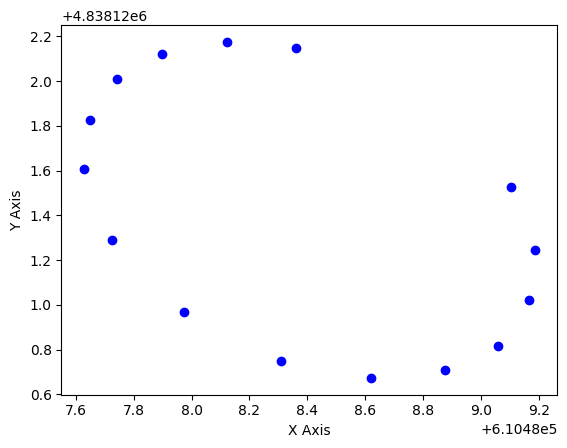

In [64]:
import matplotlib.pyplot as plt
import numpy as np

parts = "610488.3613999998 4838122.148700001 -0.0000234999999975, 610488.1238000002 4838122.174799999 -0.0000234999999975, 610487.8975999998 4838122.119999999 -0.0000234999999975, 610487.7412 4838122.011 -0.0000234999999975, 610487.6490000002 4838121.8256 -0.0000234999999975, 610487.6277000001 4838121.608100001 -0.0000234999999975, 610487.7233999996 4838121.2903 -0.0000234999999975, 610487.9731000001 4838120.9661 -0.0000234999999975, 610488.3092999998 4838120.7469999995 -0.0000234999999975, 610488.6184 4838120.6732 -0.0000234999999975, 610488.8757999996 4838120.7103 -0.0000234999999975, 610489.0577999996 4838120.817600001 -0.0000234999999975, 610489.1673999997 4838121.023600001 -0.0000234999999975, 610489.1864999998 4838121.2446 -0.0000234999999975, 610489.1057000002 4838121.5283 -0.0000234999999975".split(", ")

points = [list(map(float, part.split(" "))) for part in parts]
print(points)
points = np.array(points)

# Extract x, y, z coordinates
x = points[:, 0]
y = points[:, 1]
# Plotting in 3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, c='b', marker='o')

# Labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Point Plot')

# Show plot
plt.show()

In [32]:
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString, box
import pandas as pd
import geopandas as gpd
import numpy as np
from collections import defaultdict
from math import isclose
import matplotlib.pyplot as plt

# NUMBER OF DATA POINTS
NUM_DATA_POINTS = 2000

print('Reading Shapefile...')

# Load the shapefile
points_shapefile_path = '.\\GTAA_Errors_Intersection'
points_gdf = gpd.read_file(points_shapefile_path)

print(points_gdf.head(3))

lines_shapefile_path = '.\\GTAA_errors'
lines_gdf = gpd.read_file(lines_shapefile_path)

print('Exploding Shapefiles...')
# exploding
points_gdf = points_gdf.explode(index_parts=True).reset_index()
lines_gdf = lines_gdf.explode(index_parts=True).reset_index()

points_gdf = points_gdf.reset_index()
lines_gdf = lines_gdf.reset_index()

points_gdf['id'] = points_gdf['index']
lines_gdf['id'] = lines_gdf['index']

# Step 1: Use spatial index to find intersecting line pairs
intersections = []
intersection_to_lines_map = defaultdict(set)
line_to_intersections_map = defaultdict(set)

sindex = lines_gdf.sindex  # spatial index for fast lookup


print('Computing Intersections');
for idx1, geom1 in lines_gdf.geometry.items():
    # Get possible matches using bounding box
    possible_matches_index = list(sindex.intersection(geom1.bounds))

    for idx2 in possible_matches_index:
        if idx1 >= idx2:
            continue  # Skip self and duplicate comparisons

        geom2 = lines_gdf.geometry.iloc[idx2]
        inter = geom1.intersection(geom2)

        if inter.is_empty:
            continue

        if inter.geom_type == "Point":
            inter_points = [inter]
        elif inter.geom_type == "MultiPoint":
            inter_points = list(inter.geoms)
        else: continue

        for pt in inter_points:
            # Normalize point (for hashing) by rounding coords
            rounded_pt = Point(round(pt.x, 8), round(pt.y, 8))
            intersections.append(rounded_pt)

            # Fill both maps
            intersection_to_lines_map[rounded_pt].update([idx1, idx2])
            line_to_intersections_map[idx1].add(rounded_pt)
            line_to_intersections_map[idx2].add(rounded_pt)
    
    if idx1 % 250 == 0:
        print('Done', idx1, len(intersections))

    if (idx1 + 1) % NUM_DATA_POINTS == 0:
        break

intersections = list(intersection_to_lines_map.keys())
print('Done Computing Intersections', len(intersections))
# Step 2: Deduplicate intersection points
unique_intersections = gpd.GeoSeries(intersections).drop_duplicates()
print('Done Removing Duplicates', unique_intersections.shape)

# Create GeoDataFrame for intersections
intersections_gdf = gpd.GeoDataFrame(
    geometry=unique_intersections.reset_index(drop=True), crs=points_gdf.crs)

# Make sure CRS matches
assert points_gdf.crs == intersections_gdf.crs

# Optional: define a tolerance for near matches
tolerance = 1e-7


def plot_points(point_list, points_gdf, point_list_color='red', gdf_color='blue', point_size=10):
    # Convert list of Points into a GeoDataFrame
    point_list_gdf = gpd.GeoDataFrame(geometry=point_list, crs=points_gdf.crs)

    # Plot both on the same figure
    ax = points_gdf.plot(marker='o', color=gdf_color,
                         markersize=point_size, label='GDF Points')
    point_list_gdf.plot(ax=ax, marker='x', color=point_list_color,
                        markersize=point_size, label='Point List')

    plt.legend()
    plt.xlabel("Longitude / X")
    plt.ylabel("Latitude / Y")
    plt.title("Points Comparison Plot")
    plt.grid(True)
    plt.show()


def count_zero_z_points_in_gdf(gdf, tol=0.0):
    zero_z_count = 0
    total_3d = 0

    for geom in gdf.geometry:
        if isinstance(geom, Point) and len(geom.coords[0]) == 3:
            total_3d += 1
            if abs(geom.z) <= tol:
                zero_z_count += 1

    return zero_z_count, total_3d


zero_z, total_3d = count_zero_z_points_in_gdf(points_gdf, tol=1e-6)
print(f"3D points with z=0 (±tol): {zero_z}")
print(f"Total 3D points: {total_3d}")



def to_vec3(coords):
    """Ensure a coordinate tuple has exactly 3 elements (x, y, z)."""
    if len(coords) == 2:
        return np.array([coords[0], coords[1], 0.0])
    return np.array(coords[:3])

def line_angle_vec(line: LineString) -> np.ndarray:
    """Return the normalized direction vector of a line in 3D."""
    if len(line.coords) < 2:
        return np.array([0.0, 0.0, 0.0])
    start = to_vec3(line.coords[0])
    end = to_vec3(line.coords[-1])
    vec = end - start
    norm = np.linalg.norm(vec)
    return vec / norm if norm != 0 else vec

def angle_between_vectors(v1, v2):
    """Angle in radians between two 3D vectors."""
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    if isclose(norm_product, 0.0):
        return 0.0
    cos_theta = np.clip(dot_product / norm_product, -1.0, 1.0)
    return np.arccos(cos_theta)


def dist_3d(p1: Point, p2: Point) -> float:
    """Compute 3D distance between two shapely points."""
    return np.linalg.norm(to_vec3(p1.coords[0]) - to_vec3(p2.coords[0]))

def weighted_avg_dist(intersection, other_points):
    """Weighted average of 3D distances to other intersections."""
    dists = np.array([dist_3d(intersection, pt) for pt in other_points if not pt.equals(intersection)])
    if len(dists) == 0:
        return 0.0
    weights = 1 / (dists + 1e-6)
    return np.average(dists, weights=weights)

def get_bbox_dimensions(lines):
    """3D bounding box dimensions from a group of lines."""
    all_coords = [coord for line in lines for coord in line.coords]
    arr = np.array(all_coords)
    if arr.shape[0] == 0:
        return 0.0, 0.0
    zmin, zmax = arr[:, 2].min(), arr[:, 2].max()
    ymin, ymax = arr[:, 1].min(), arr[:, 1].max()
    xmin, xmax = arr[:, 0].min(), arr[:, 0].max()
    height = zmax - zmin
    width = np.linalg.norm([xmax - xmin, ymax - ymin])
    return height, width


def point_exists_within_tolerance(pt, other_points, tol=1e-8):
    """Return True if any point in other_points is within tolerance of pt."""
    pt_vec = to_vec3(pt.coords[0])
    for other in other_points:
        other_vec = to_vec3(other.coords[0])
        if np.linalg.norm(pt_vec - other_vec) <= tol:
            return True
    return False

print('Computing First Set Of Metrics')

# Prepare output records
records = []

# Cache intersection angles for variance later
intersection_angles = {}

def compute_metrics():
    k = 0
    for inter_pt in intersections:
        lines_idxs = intersection_to_lines_map[inter_pt]
        lines = [lines_gdf.geometry[i] for i in lines_idxs]

        num_of_lines = len(lines)

        # Angle calculations
        ref_vec = line_angle_vec(lines[0])
        angles = [angle_between_vectors(
            ref_vec, line_angle_vec(l)) for l in lines[1:]]
        avg_angle_of_intersection = np.mean(angles) if angles else 0.0
        intersection_angles[inter_pt] = avg_angle_of_intersection

        involved_intersections = []
        weighted_dists = []

        min_dist_to_ep = float("inf")
        max_dist_to_ep = 0.0

        for idx in lines_idxs:
            inters = list(line_to_intersections_map[idx])
            involved_intersections.extend(inters)

            for pt in inters:
                if pt.equals(inter_pt):
                    continue
                d = dist_3d(inter_pt, pt)
                weighted_dists.append((d, 1 / (d + 1e-6)))

            line_geom = lines_gdf.geometry[idx]
            for ep in [Point(line_geom.coords[0]), Point(line_geom.coords[-1])]:
                d_ep = dist_3d(inter_pt, ep)
                min_dist_to_ep = min(min_dist_to_ep, d_ep)
                max_dist_to_ep = max(max_dist_to_ep, d_ep)

        num_of_involved_line_intersections = len(set(involved_intersections))

        if weighted_dists:
            dists, weights = zip(*weighted_dists)
            vicinity_of_involved_line_intersections = np.average(
                dists, weights=weights)
        else:
            vicinity_of_involved_line_intersections = 0.0

        height, width = get_bbox_dimensions(lines)

        # Error check (existence in points_GDF without sjoin)
        error_flag = int(not point_exists_within_tolerance(
            inter_pt, points_gdf.geometry))

        records.append({
            'geometry': inter_pt,
            'num_of_lines': num_of_lines,
            'avg_angle_of_intersection': avg_angle_of_intersection,
            'num_of_involved_line_intersections': num_of_involved_line_intersections,
            'vicinity_of_involved_line_intersections': vicinity_of_involved_line_intersections,
            'min_distance_to_endpoint': min_dist_to_ep,
            'max_distance_to_endpoint': max_dist_to_ep,
            'intersection_bounding_box_height': height,
            'intersection_bounding_box_width': width,
            'error': error_flag
        })

        if k % 500 == 0:
            print('Done', k)
        k += 1

        if (k+1) % NUM_DATA_POINTS == 0:
            break

# compute_metrics()

print('Computing Second Set Of Metrics')





# # Step 2: intersecting_angles_variance + vicinity_to_intersections
# k = 0
# for record in records:
#     pt = record['geometry']
#     lines_idxs = intersection_to_lines_map[pt]
#     variances = []

#     for idx in lines_idxs:
#         other_pts = line_to_intersections_map[idx]
#         other_angles = [intersection_angles.get(
#             p, 0.0) for p in other_pts if not p.equals(pt)]
#         if not other_angles:
#             continue
#         variance = np.var(other_angles)
#         variances.append(variance)

#     record['intersecting_angles_variance'] = np.mean(
#         variances) if variances else 0.0

#     other_pts = [r['geometry']
#                  for r in records if not r['geometry'].equals(pt)]
#     record['vicinity_to_intersections'] = weighted_avg_dist(pt, other_pts)

#     if k % 500 == 0:
#         print('Done', k)
#     k += 1
#     if (k+1) % NUM_DATA_POINTS == 0:
#         break


print('Done Computing Second Set Of Metrics')

# Final GeoDataFrame
final_gdf = gpd.GeoDataFrame(records, crs=lines_gdf.crs)
final_gdf.to_csv("intersection_analysis_3D.csv", index=False)

print("Saved 3D intersection analysis to intersection_analysis_3D.csv")

Reading Shapefile...
   Id                            geometry
0   0  POINT Z (611548.567 4838056.456 0)
1   0   POINT Z (611541.452 4838058.75 0)
2   0    POINT Z (611547.63 4838074.62 0)
Exploding Shapefiles...
Computing Intersections
Done 0 16
Done 250 5974
Done 500 6322
Done 750 7019
Done 1000 8813
Done 1250 10626
Done 1500 11909
Done 1750 13575
Done Computing Intersections 3738
Done Removing Duplicates (3738,)
3D points with z=0 (±tol): 414
Total 3D points: 414
Computing First Set Of Metrics
Computing Second Set Of Metrics
Done Computing Second Set Of Metrics


ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'